In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import cv2

from keras.utils import Sequence

import segmentation_models as sm
from keras.metrics import MeanIoU, OneHotMeanIoU

from matplotlib import pyplot as plt

import random

from helpers import *
from labels import *
from batch_generator import DataGenerator
from mini_unet import mini_unet

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

import time

Segmentation Models: using `keras` framework.


In [2]:
DATA_DIR = 'G:/Mon Drive/Colab_Notebooks/future_vision_transport/data/'

# creating lists of paths to images

x_train_dir = os.path.join(DATA_DIR, 'train_images/train')
y_train_dir = os.path.join(DATA_DIR, 'train_masks/train')

x_val_dir = os.path.join(DATA_DIR, 'val_images/val')
y_val_dir = os.path.join(DATA_DIR, 'val_masks/val')

x_test_dir = os.path.join(DATA_DIR, 'test_images/test')
y_test_dir = os.path.join(DATA_DIR, 'test_masks/test')

x_train_paths = getPaths(x_train_dir)
y_train_paths = getPaths(y_train_dir)

x_val_paths = getPaths(x_val_dir)
y_val_paths = getPaths(y_val_dir)

x_test_paths = getPaths(x_test_dir)
y_test_paths = getPaths(y_test_dir)

# creating lists of paths to images: samples for testing models

x_train_paths_sample = x_train_paths[:800]
y_train_paths_sample = y_train_paths[:800]

x_val_paths_sample = x_val_paths[:150]
y_val_paths_sample = y_val_paths[:150]

x_test_paths_sample = x_test_paths[:100]
y_test_paths_sample = y_test_paths[:100]

In [3]:
def model_test(architecture, backbone, filename, dims, loss_function, augmentation=False):

    ''' Architectures to test: sm.Unet, sm.Linknet, sm.PSPNet '''
    ''' Backbones to test: 'resnet34', 'vgg16' '''
    ''' Augmentation == True / False '''
    ''' Filename: string '''

    model = architecture(backbone, encoder_weights='imagenet', input_shape=(dims, dims, 3), classes=8, activation='softmax')
    model.compile('Adam', loss=loss_function, metrics=OneHotMeanIoU(num_classes=8, name='mean_iou'))

    path = filename + '.h5'
    checkpoint = ModelCheckpoint(filepath=path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_mean_iou', patience=3, mode='max', min_delta=0.001)

    train_gen = DataGenerator(x_train_paths_sample, y_train_paths_sample, batch_size=8, dims=dims, backbone=backbone, shuffle=True, augmentation=augmentation)
    val_gen = DataGenerator(x_val_paths_sample, y_val_paths_sample, batch_size=8, dims=dims, backbone=backbone, shuffle=False, augmentation=False)
    test_gen = DataGenerator(x_test_paths_sample, y_test_paths_sample, batch_size=8, dims=dims, backbone=backbone, shuffle=False, augmentation=False)

    start = time.time()

    history = model.fit(train_gen, validation_data=val_gen, epochs=10, workers=8, callbacks=[checkpoint, early_stopping])

    end = time.time()

    training_time = end-start
    scores = model.evaluate(test_gen)

    #plot the training and validation IoU and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['mean_iou']
    val_acc = history.history['val_mean_iou']

    plt.plot(epochs, acc, 'y', label='Training IoU')
    plt.plot(epochs, val_acc, 'r', label='Validation IoU')
    plt.title('Training and validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()

    results = {
        'Model name': filename,
        str(model.metrics_names[0]): scores[0],
        str(model.metrics_names[1]): scores[1],
        'Training time': training_time
    }

    return results

def display_predictions(model, dims, quantity=3):

    for i in range (0, quantity):

        index = random.randint(0, 100)

        im = cv2.resize(cv2.cvtColor(cv2.imread(x_test_paths_sample[index]), cv2.COLOR_BGR2RGB), (dims,dims))
        pred_mask = model.predict(im.reshape(1,dims,dims,3))
        pred_mask_argmax = np.argmax(pred_mask, axis=3)

        real_mask = cv2.resize((cv2.imread(y_test_paths_sample[index],0)), (dims,dims))
        real_mask = coarsify_ohe(real_mask)
        real_mask = np.argmax(real_mask, axis=2)

        plt.figure(figsize=(12, 8))
        plt.subplot(131)
        plt.imshow(pred_mask_argmax.reshape(dims,dims,1), cmap='gray')
        plt.title('Predicted mask')
        plt.subplot(132)
        plt.imshow(real_mask, cmap='gray')
        plt.title('True mask')
        plt.subplot(133)
        plt.imshow(im)
        plt.title('Original image')
        plt.show()

## 1. Data Exploration and Examples

### 1.1. Images and masks

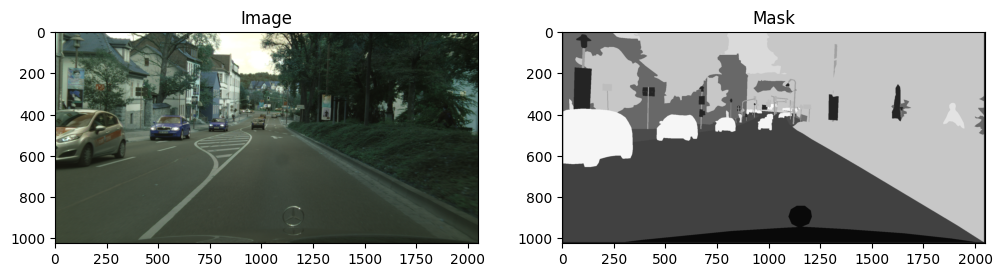

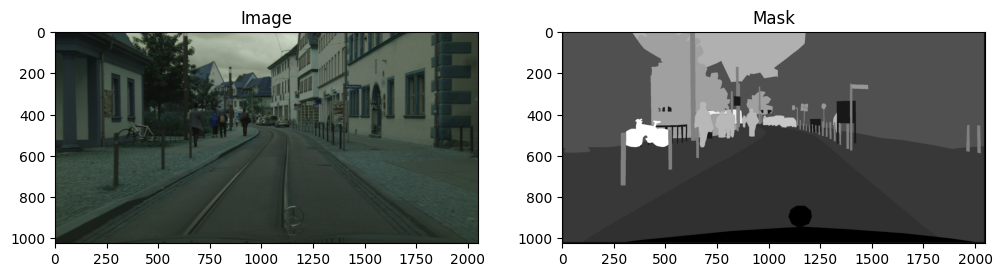

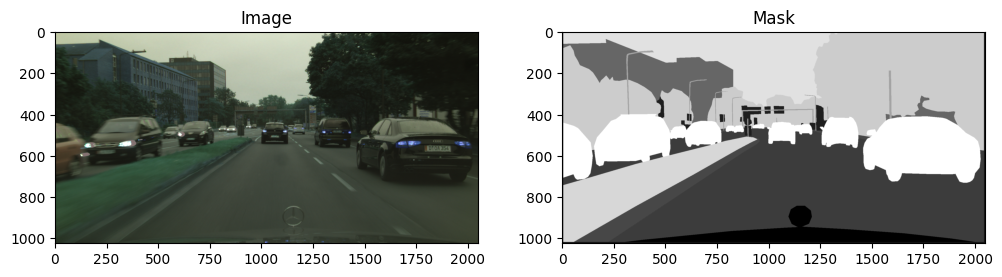

In [4]:
rand_indexes = [random.randint(0, len(x_train_paths)), random.randint(0, len(x_train_paths)), random.randint(0, len(x_train_paths))]

img_for_plot = [cv2.imread(x_train_paths[rand_indexes[0]], 1),
                cv2.imread(x_train_paths[rand_indexes[1]], 1),
                cv2.imread(x_train_paths[rand_indexes[2]], 1)]
mask_for_plot = [cv2.imread(y_train_paths[rand_indexes[0]], 0),
                cv2.imread(y_train_paths[rand_indexes[1]], 0),
                cv2.imread(y_train_paths[rand_indexes[2]], 0)]


for i in range (0,3):
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(img_for_plot[i])
    plt.title('Image')
    plt.subplot(122)
    plt.imshow(mask_for_plot[i], cmap='gray')
    plt.title('Mask')
    plt.show()

### 1.2. Examples of transformations

In [6]:
mask_for_plot_ohe = [coarsify_ohe(mask) for mask in mask_for_plot]

imgs, masks = augment_batch(img_for_plot, np.array(mask_for_plot_ohe))

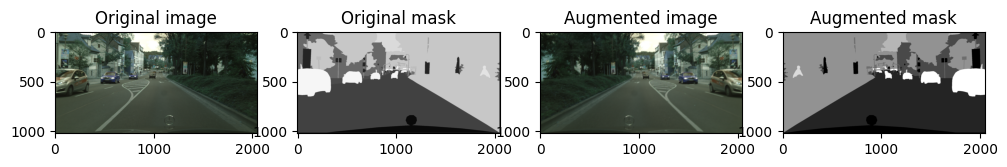

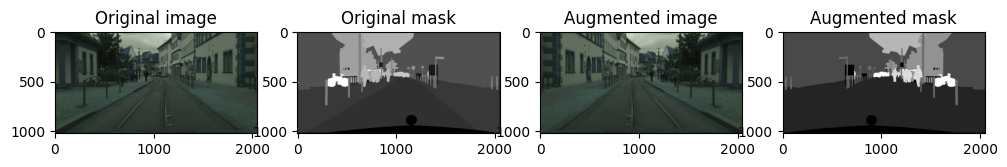

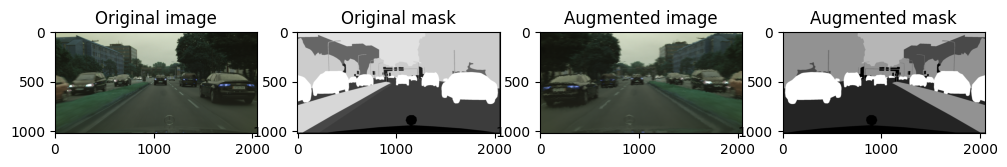

In [7]:
for i in range(0, len(imgs)):
    plt.figure(figsize=(12,8))
    plt.subplot(141)
    plt.imshow(img_for_plot[i])
    plt.title('Original image')
    plt.subplot(142)
    plt.imshow(mask_for_plot[i], cmap='gray')
    plt.title('Original mask')
    plt.subplot(143)
    plt.imshow(imgs[i])
    plt.title('Augmented image')
    plt.subplot(144)
    plt.imshow(np.argmax(masks[i], axis=2),cmap='gray')
    plt.title('Augmented mask')
    plt.show()

## 2. Model testing

In [20]:
model_benchmark = pd.DataFrame(columns=['Model name', 'Loss', 'Mean IoU', 'Training time'])

### 2.1. Baseline model: Mini U-net

In [4]:
mini_unet.compile(loss = sm.losses.categorical_crossentropy, metrics = OneHotMeanIoU(num_classes=8, name='mean_iou'))
print("Mini U-net input layer: " + str(mini_unet.input))
print("Mini U-net output layer: " + str(mini_unet.output))

Mini U-net input layer: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Mini U-net output layer: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 8), dtype=tf.float32, name=None), name='conv8/Softmax:0', description="created by layer 'conv8'")


In [5]:
mini_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 256, 256, 32  9248        ['conv1_1[0][0]']                
                                )                                                             

In [5]:
filepath = 'baseline.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

early_stopping = EarlyStopping(monitor='val_mean_iou',
                                patience=3,
                                mode='max',
                                min_delta=0.001)

In [6]:
train_gen = DataGenerator(x_train_paths_sample, y_train_paths_sample, batch_size=16, shuffle=True, augmentation=False, dims=256, backbone='none')
val_gen = DataGenerator(x_val_paths_sample, y_val_paths_sample, batch_size=16, shuffle=False, augmentation=False, dims=256, backbone='none')

start = time.time()

history = mini_unet.fit(
            train_gen, 
            validation_data = val_gen,
            epochs=10,
            #use_multiprocessing=True,
            workers=8,
            callbacks=[checkpoint, early_stopping]
)

end = time.time()
training_time = end-start

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.4736 - mean_iou: 0.1121
Epoch 1: val_loss improved from inf to 0.25834, saving model to baseline.h5
50/50 [==============================] - 412s 7s/step - loss: 0.4736 - mean_iou: 0.1121 - val_loss: 0.2583 - val_mean_iou: 0.1064
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.1945 - mean_iou: 0.1881
Epoch 2: val_loss improved from 0.25834 to 0.18112, saving model to baseline.h5
50/50 [==============================] - 414s 7s/step - loss: 0.1945 - mean_iou: 0.1881 - val_loss: 0.1811 - val_mean_iou: 0.2293
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.1820 - mean_iou: 0.2206
Epoch 3: val_loss did not improve from 0.18112
50/50 [==============================] - 433s 8s/step - loss: 0.1820 - mean_iou: 0.2206 - val_loss: 0.2002 - val_mean_iou: 0.1366
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.1567 - mean_iou: 0.2550
Epoch 4: val_loss improved from

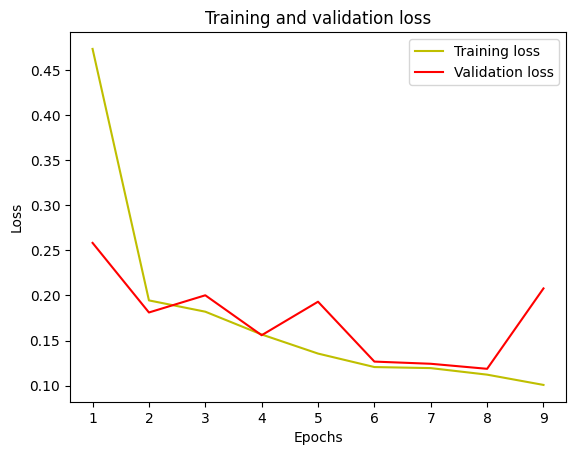

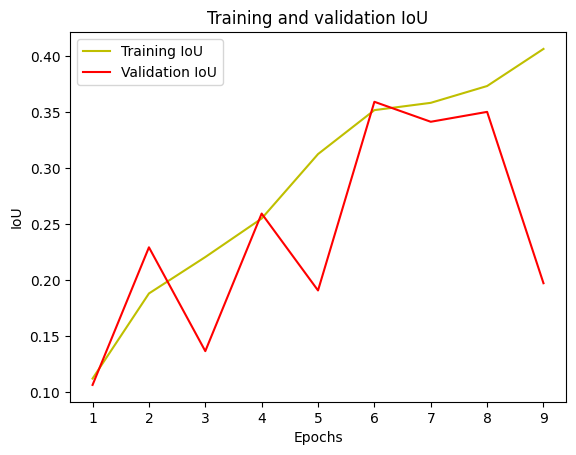

In [7]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mean_iou']
val_acc = history.history['val_mean_iou']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [9]:
test_gen = DataGenerator(x_test_paths_sample, y_test_paths_sample, batch_size=16, shuffle=False, augmentation=False, dims=256, backbone='none')
scores = mini_unet.evaluate(test_gen)
print("Training time: " + str(training_time))
print("Scores: " + str(scores))

7/7 [==============================] - 55s 8s/step - loss: 0.1705 - mean_iou: 0.2791
Training time: 3864.7033264636993
Scores: [0.17053218185901642, 0.27910804748535156]


In [10]:
mini_unet.metrics_names

['loss', 'mean_iou']

In [11]:
results = {
        'Model name': 'baseline',
        'Loss': scores[0],
        'Mean IoU': scores[1],
        'Training time': training_time
}
results

{'Model name': 'baseline',
 'Loss': 0.17053218185901642,
 'Mean IoU': 0.27910804748535156,
 'Training time': 3864.7033264636993}

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:
model_benchmark = model_benchmark.append(results, ignore_index=True)

1/1 [==============================] - 1s 515ms/step


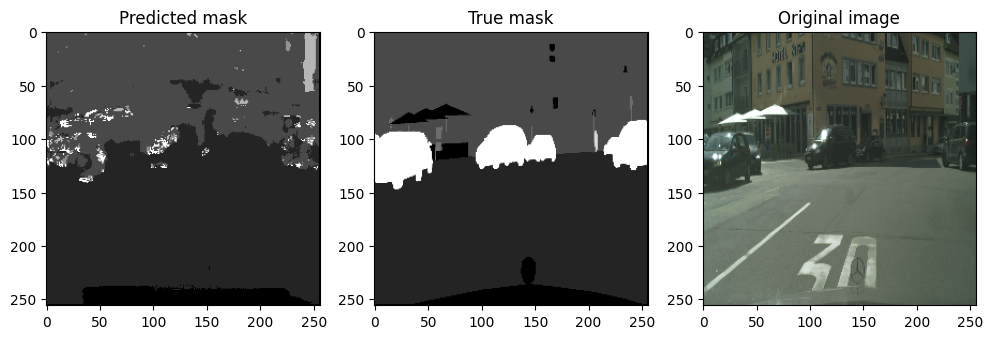

1/1 [==============================] - 0s 36ms/step


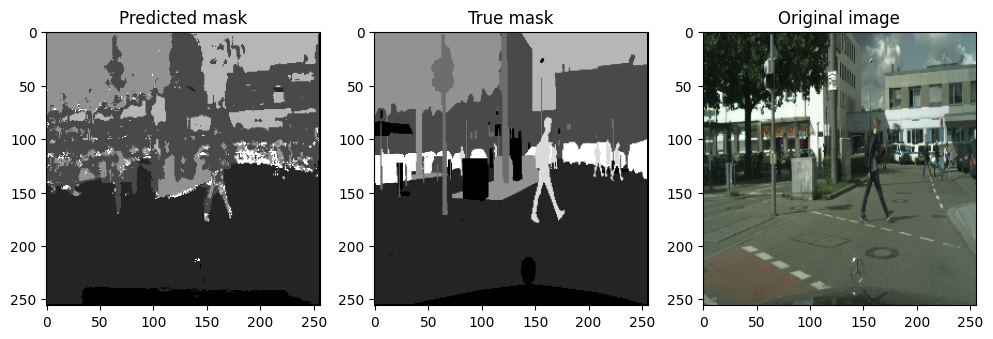

1/1 [==============================] - 0s 37ms/step


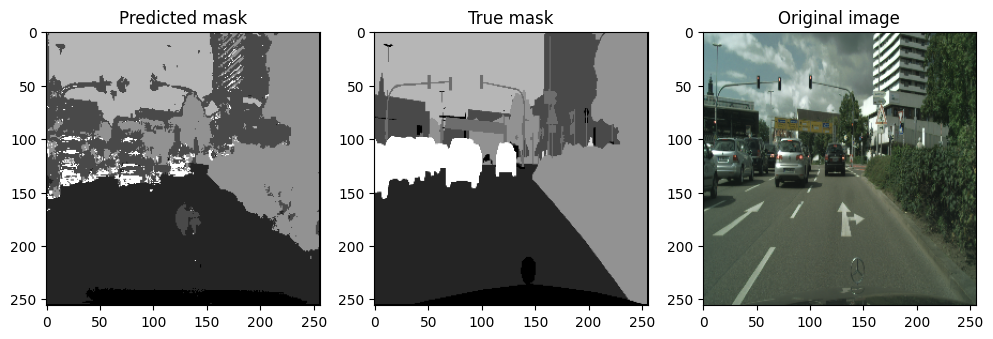

In [13]:
baseline = load_model('baseline.h5')
display_predictions(model=baseline, quantity=3, dims=256)

### 2.2. Segmentation models

#### 2.2.1. Architecture: U-Net, Backbone: VGG16

***Categorical focal dice loss***

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.5920 - mean_iou: 0.3779
Epoch 1: val_loss improved from inf to 0.57423, saving model to unet_vgg16_dice.h5
100/100 [==============================] - 361s 3s/step - loss: 0.5920 - mean_iou: 0.3779 - val_loss: 0.5742 - val_mean_iou: 0.3866
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.3797 - mean_iou: 0.5529
Epoch 2: val_loss improved from 0.57423 to 0.49690, saving model to unet_vgg16_dice.h5
100/100 [==============================] - 377s 3s/step - loss: 0.3797 - mean_iou: 0.5529 - val_loss: 0.4969 - val_mean_iou: 0.4406
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3310 - mean_iou: 0.5954
Epoch 3: val_loss did not improve from 0.49690
100/100 [==============================] - 352s 3s/step - loss: 0.3310 - mean_iou: 0.5954 - val_loss: 0.5068 - val_mean_iou: 0.4320
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.3014 - mean_iou: 0.6226
Epo

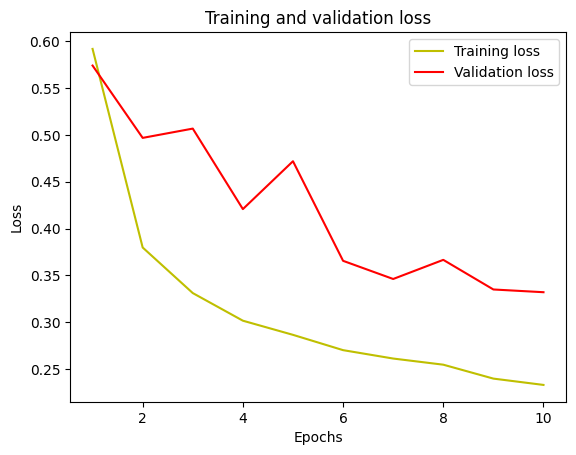

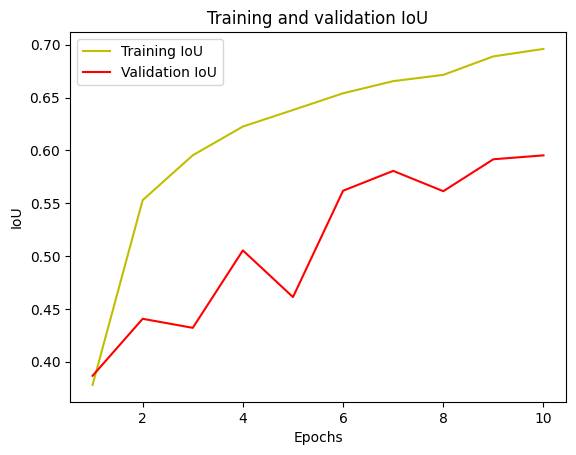

In [14]:
unet_vgg16_dice_results = model_test(architecture=sm.Unet, backbone='vgg16', filename='unet_vgg16_dice', loss_function=sm.losses.categorical_focal_dice_loss, dims=256, augmentation=False)

In [21]:
print(unet_vgg16_dice_results)

{'Model name': 'unet_vgg16_dice', 'Loss': 0.28977498412132263, 'Mean IoU': 0.6379003524780273, 'Training time': 3615.0278668403625}


In [16]:
unet_vgg16_dice_results = {'Model name': 'unet_vgg16_dice', 'Loss': 0.28977498412132263, 'Mean IoU': 0.6379003524780273, 'Training time': 3615.0278668403625}

In [31]:
model_benchmark = model_benchmark.append(unet_vgg16_dice_results, ignore_index=True)

1/1 [==============================] - 1s 585ms/step


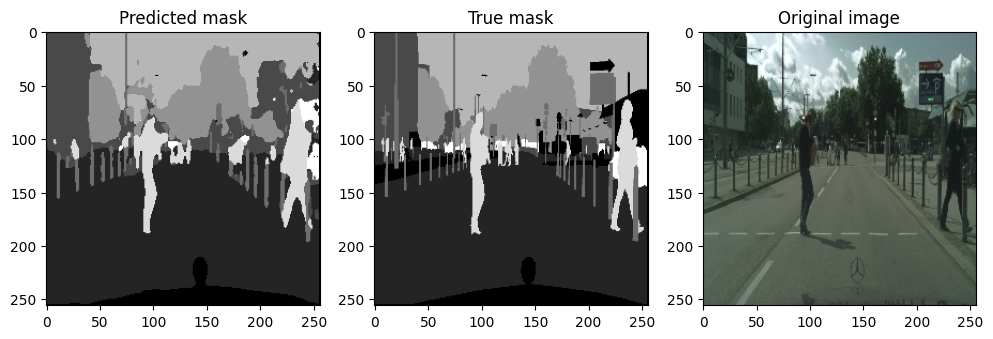

1/1 [==============================] - 0s 37ms/step


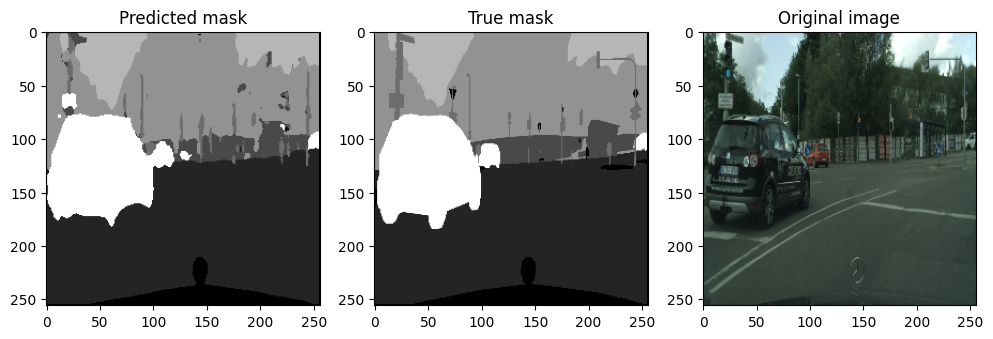

1/1 [==============================] - 0s 43ms/step


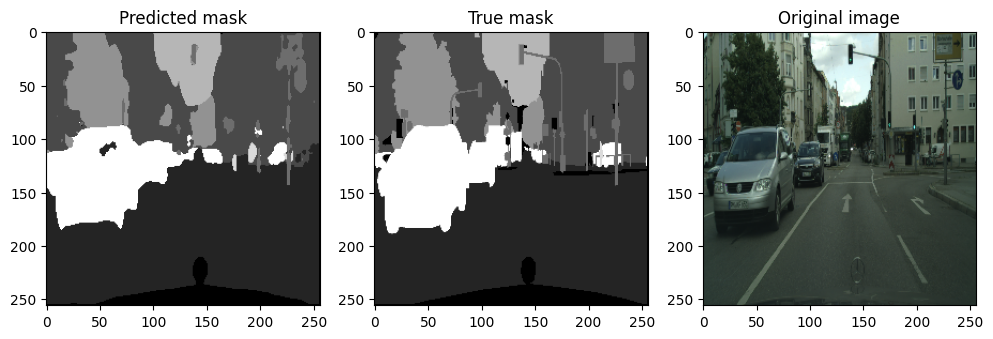

In [20]:
unet_vgg16_dice = load_model('unet_vgg16_dice.h5', custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})
display_predictions(model=unet_vgg16_dice, quantity=3, dims=256)

***Categorical focal jaccard loss***

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.7001 - mean_iou: 0.3643
Epoch 1: val_loss improved from inf to 0.68202, saving model to unet_vgg16_jaccard.h5
100/100 [==============================] - 359s 3s/step - loss: 0.7001 - mean_iou: 0.3643 - val_loss: 0.6820 - val_mean_iou: 0.4088
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5130 - mean_iou: 0.5231
Epoch 2: val_loss did not improve from 0.68202
100/100 [==============================] - 375s 3s/step - loss: 0.5130 - mean_iou: 0.5231 - val_loss: 0.7420 - val_mean_iou: 0.3303
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.4537 - mean_iou: 0.5866
Epoch 3: val_loss improved from 0.68202 to 0.57373, saving model to unet_vgg16_jaccard.h5
100/100 [==============================] - 351s 3s/step - loss: 0.4537 - mean_iou: 0.5866 - val_loss: 0.5737 - val_mean_iou: 0.4849
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.4200 - mean_iou: 0.61

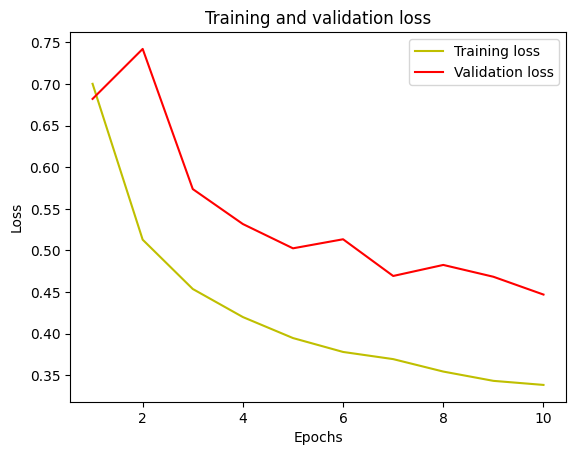

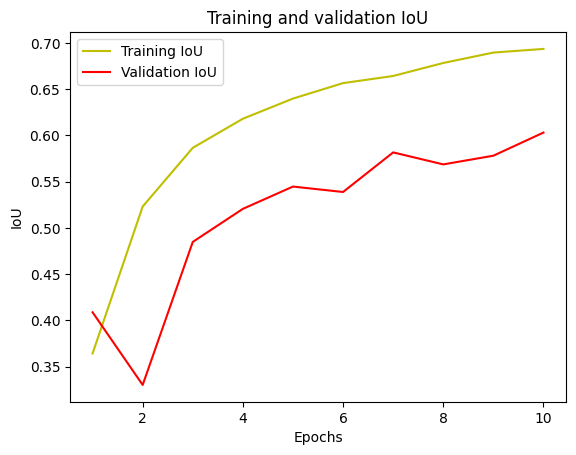

In [13]:
unet_vgg16_jaccard_results = model_test(architecture=sm.Unet, backbone='vgg16', filename='unet_vgg16_jaccard', loss_function=sm.losses.categorical_focal_jaccard_loss, dims=256, augmentation=False)

In [26]:
print(unet_vgg16_jaccard_results)

{'Model name': 'unet_vgg16_jaccard', 'Loss': 0.38867560029029846, 'Mean IoU': 0.6439199447631836, 'Training time': 3843.331433057785}


In [34]:
model_benchmark = model_benchmark.append(unet_vgg16_jaccard_results, ignore_index=True)

1/1 [==============================] - 1s 718ms/step


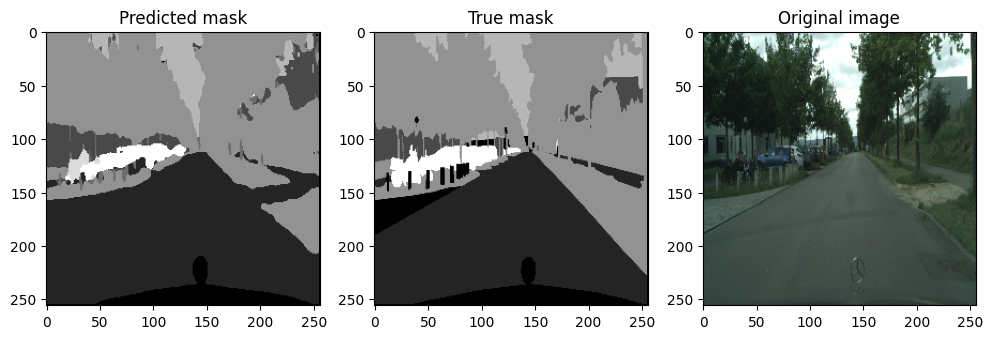

1/1 [==============================] - 0s 43ms/step


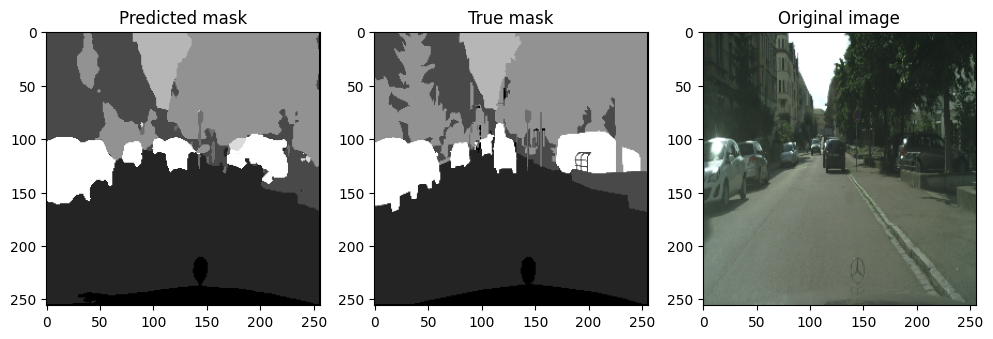

1/1 [==============================] - 0s 43ms/step


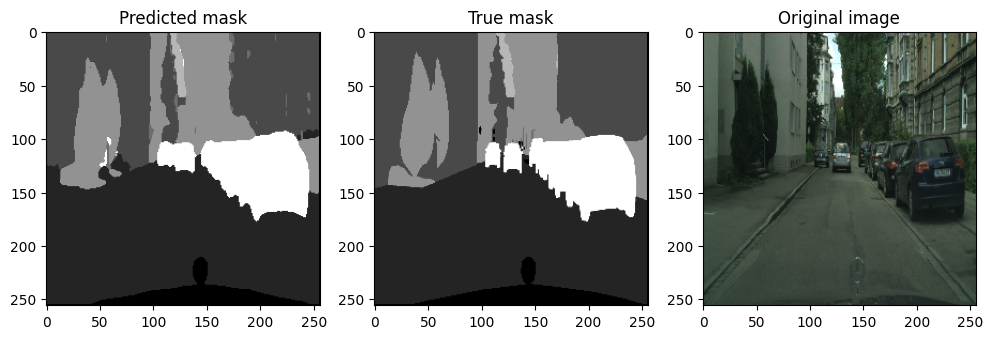

In [9]:
unet_vgg16_jaccard = load_model('unet_vgg16_jaccard.h5', custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss})
display_predictions(model=unet_vgg16_jaccard, quantity=3, dims=256)

#### 2.2.2. Architecture: U-Net, Backbone: Resnet34

In [42]:
architecture = sm.Unet
backbone = 'resnet34'
loss = sm.losses.categorical_focal_jaccard_loss
metrics = [OneHotMeanIoU(num_classes=8, name='mean_iou')]

model_aug = architecture(backbone, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=8, activation='softmax')
model_aug.compile('Adam', loss=loss, metrics=metrics)

In [43]:
train_gen = DataGenerator(x_train_paths, y_train_paths, batch_size=16, shuffle=True, augmentation=False)
val_gen = DataGenerator(x_val_paths, y_val_paths, batch_size=16, shuffle=True, augmentation=False)

start = time.time()

history = model_aug.fit(
            train_gen, 
            validation_data = val_gen,
            epochs=20,
            #use_multiprocessing=True,
            workers=12,
            callbacks=[checkpoint, early_stopping]
)

end = time.time()
training_time = end-start

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.5260 - mean_iou: 0.5351
Epoch 1: val_loss improved from inf to 0.80996, saving model to my_best_model_aug.epoch01-loss0.81.h5
164/164 [==============================] - 1185s 7s/step - loss: 0.5260 - mean_iou: 0.5351 - val_loss: 0.8100 - val_mean_iou: 0.3248
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.3708 - mean_iou: 0.6610
Epoch 2: val_loss improved from 0.80996 to 0.47419, saving model to my_best_model_aug.epoch02-loss0.47.h5
164/164 [==============================] - 1192s 6s/step - loss: 0.3708 - mean_iou: 0.6610 - val_loss: 0.4742 - val_mean_iou: 0.5738
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.3365 - mean_iou: 0.6917
Epoch 3: val_loss improved from 0.47419 to 0.37900, saving model to my_best_model_aug.epoch03-loss0.38.h5
164/164 [==============================] - 1114s 6s/step - loss: 0.3365 - mean_iou: 0.6917 - val_loss: 0.3790 - val_mean_iou: 0.6549

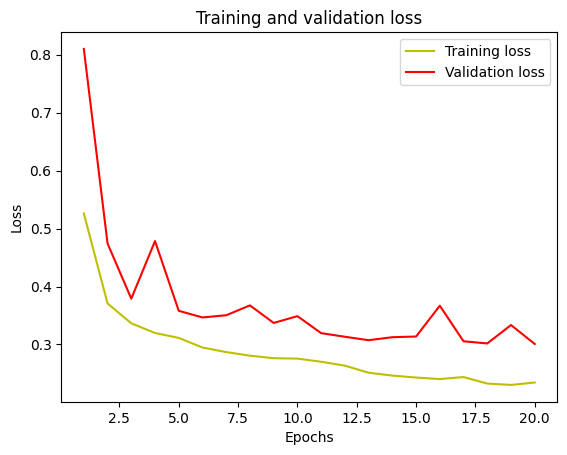

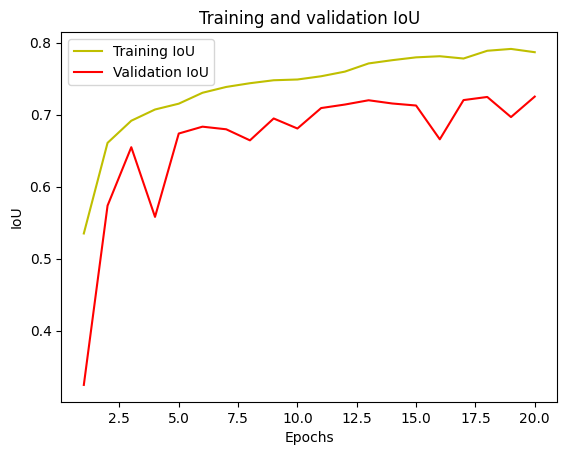

Training time: 22829.152702093124


In [47]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mean_iou']
val_acc = history.history['val_mean_iou']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

print("Training time: " + str(training_time))

In [23]:
model = load_model("my_best_model_aug.epoch20-loss0.30.h5", custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss})

In [24]:
test_gen = DataGenerator(x_test_paths, y_test_paths, batch_size=8, shuffle=False, augmentation=False)

In [25]:
score_unet_resnet = model.evaluate(test_gen)

45/45 [==============================] - 325s 7s/step - loss: 0.2943 - mean_iou: 0.7364


1/1 [==============================] - 3s 3s/step


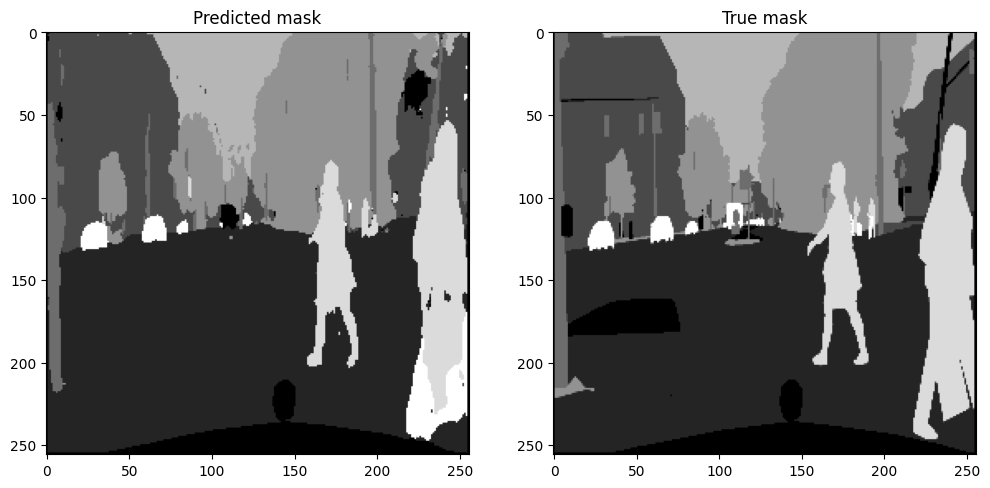

In [16]:
index = 5

im = cv2.resize(cv2.cvtColor(cv2.imread(x_test_paths_sample[index]), cv2.COLOR_BGR2RGB), (256,256))

pred_mask = model.predict(im.reshape(1,256,256,3))
pred_mask_argmax = np.argmax(pred_mask, axis=3)

real_mask = cv2.resize((cv2.imread(y_test_paths_sample[index],0)), (256,256))
real_mask = coarsify_ohe(real_mask)
real_mask = np.argmax(real_mask, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(pred_mask_argmax.reshape(256,256,1), cmap='gray')
plt.title('Predicted mask')
plt.subplot(122)
plt.imshow(real_mask, cmap='gray')
plt.title('True mask')
plt.show()

In [53]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = 'my_best_model_aug2.epoch{epoch:02d}-loss{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

early_stopping = EarlyStopping(monitor='val_mean_iou',
                                patience=3,
                                mode='max',
                                min_delta=0.001)

In [55]:
architecture = sm.Unet
backbone = 'resnet34'
loss = sm.losses.categorical_focal_jaccard_loss
metrics = [OneHotMeanIoU(num_classes=8, name='mean_iou')]

model_aug = architecture(backbone, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=8, activation='softmax')
model_aug.compile('Adam', loss=loss, metrics=metrics)

#### 2.2.2. U-Net backbone Resnet34

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.5046 - mean_iou: 0.4639
Epoch 1: val_loss improved from inf to 0.74288, saving model to unet_resnet34_dice.h5
100/100 [==============================] - 415s 4s/step - loss: 0.5046 - mean_iou: 0.4639 - val_loss: 0.7429 - val_mean_iou: 0.2809
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.3333 - mean_iou: 0.5977
Epoch 2: val_loss improved from 0.74288 to 0.43161, saving model to unet_resnet34_dice.h5
100/100 [==============================] - 415s 4s/step - loss: 0.3333 - mean_iou: 0.5977 - val_loss: 0.4316 - val_mean_iou: 0.5149
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2913 - mean_iou: 0.6378
Epoch 3: val_loss improved from 0.43161 to 0.38683, saving model to unet_resnet34_dice.h5
100/100 [==============================] - 418s 4s/step - loss: 0.2913 - mean_iou: 0.6378 - val_loss: 0.3868 - val_mean_iou: 0.5523
Epoch 4/10
100/100 [==============================

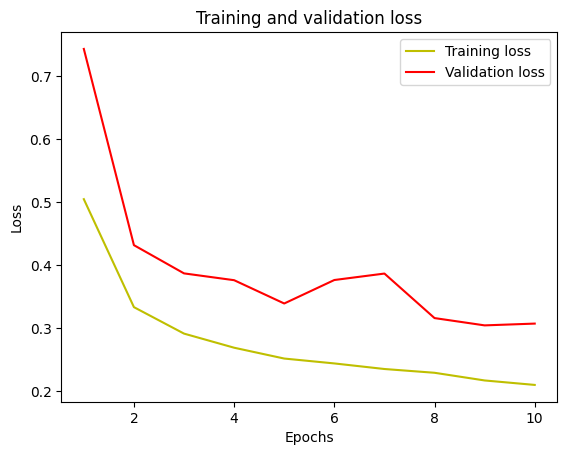

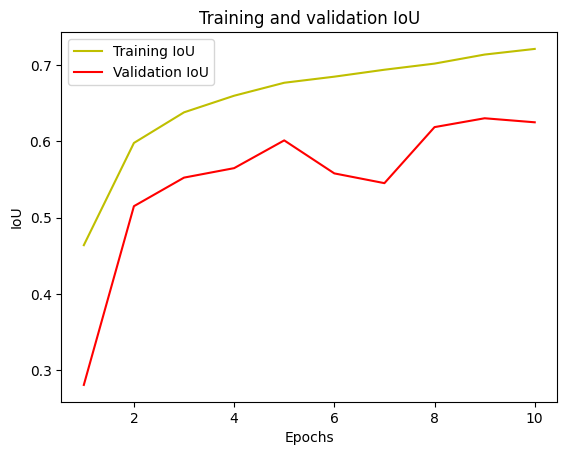

In [4]:
unet_resnet34_dice_results = model_test(architecture=sm.Unet, backbone='resnet34', filename='unet_resnet34_dice', loss_function=sm.losses.categorical_focal_dice_loss, dims=256, augmentation=False)

In [5]:
print(unet_resnet34_dice_results)

{'Model name': 'unet_resnet34_dice', 'loss': 0.2881782054901123, 'mean_iou': 0.6439576148986816, 'Training time': 4027.2961010932922}


In [36]:
model_benchmark = model_benchmark.append(unet_resnet34_dice_results, ignore_index=True)

1/1 [==============================] - 2s 2s/step


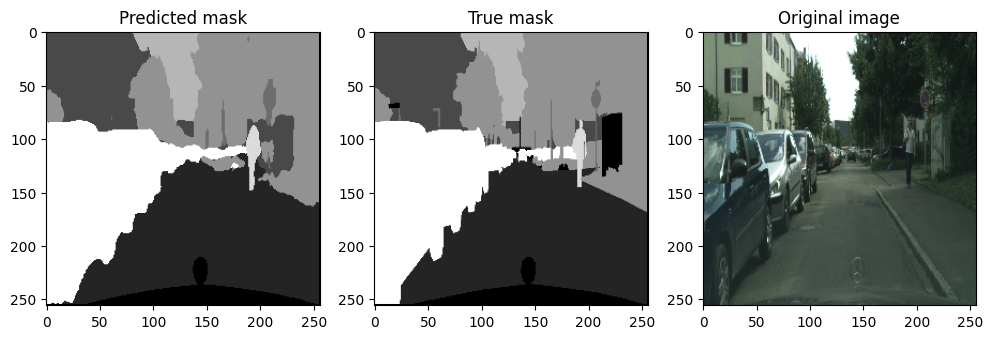

1/1 [==============================] - 0s 48ms/step


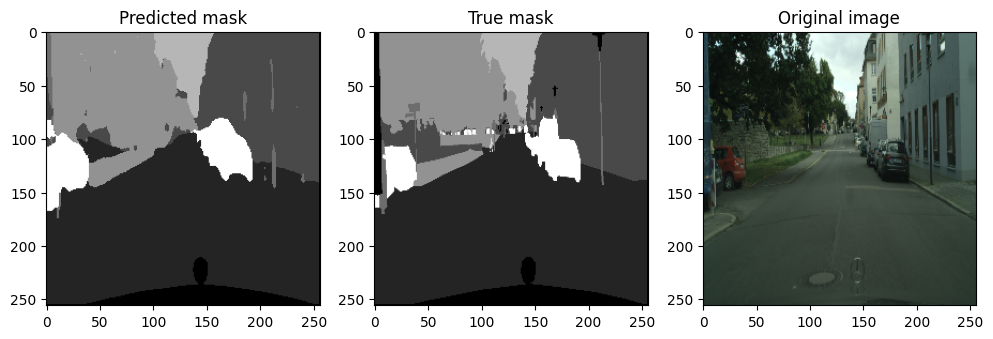

1/1 [==============================] - 0s 47ms/step


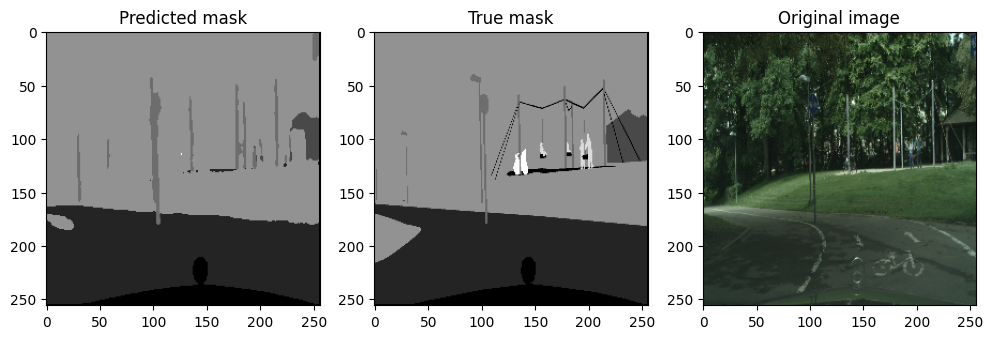

In [6]:
unet_resnet34_dice = load_model('unet_resnet34_dice.h5', custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})
display_predictions(model=unet_resnet34_dice, quantity=3, dims=256)

#### 2.2.3. Architecture: Linknet, Backbone: Resnet34 (or best backbone)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6219 - mean_iou: 0.3336
Epoch 1: val_loss improved from inf to 0.65265, saving model to linknet_vgg16_dice.h5
100/100 [==============================] - 369s 3s/step - loss: 0.6219 - mean_iou: 0.3336 - val_loss: 0.6527 - val_mean_iou: 0.3202
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.4532 - mean_iou: 0.4834
Epoch 2: val_loss did not improve from 0.65265
100/100 [==============================] - 352s 3s/step - loss: 0.4532 - mean_iou: 0.4834 - val_loss: 0.6748 - val_mean_iou: 0.2960
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3766 - mean_iou: 0.5529
Epoch 3: val_loss did not improve from 0.65265
100/100 [==============================] - 350s 3s/step - loss: 0.3766 - mean_iou: 0.5529 - val_loss: 0.6775 - val_mean_iou: 0.2769
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.3357 - mean_iou: 0.5913
Epoch 4: val_loss improved from 0.65265 

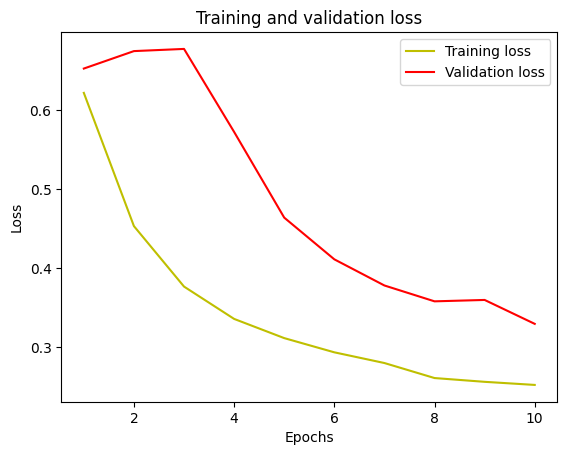

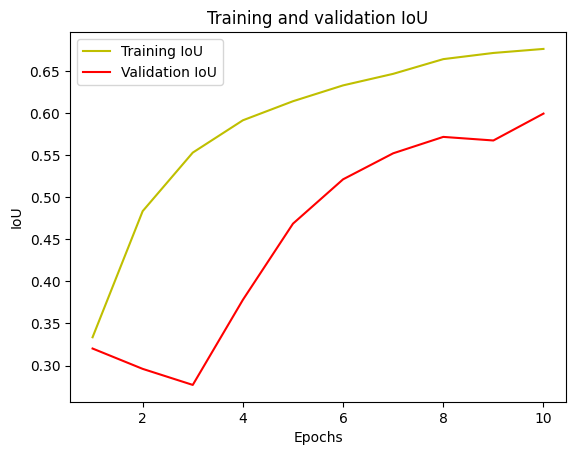

In [7]:
linknet_vgg16_dice_results = model_test(architecture=sm.Linknet, backbone='vgg16', filename='linknet_vgg16_dice', loss_function=sm.losses.categorical_focal_dice_loss, dims=256, augmentation=False)

In [8]:
print(linknet_vgg16_dice_results)

{'Model name': 'linknet_vgg16_dice', 'loss': 0.29865601658821106, 'mean_iou': 0.6298915147781372, 'Training time': 3583.629345178604}


In [38]:
model_benchmark = model_benchmark.append(linknet_vgg16_dice_results, ignore_index=True)

1/1 [==============================] - 2s 2s/step


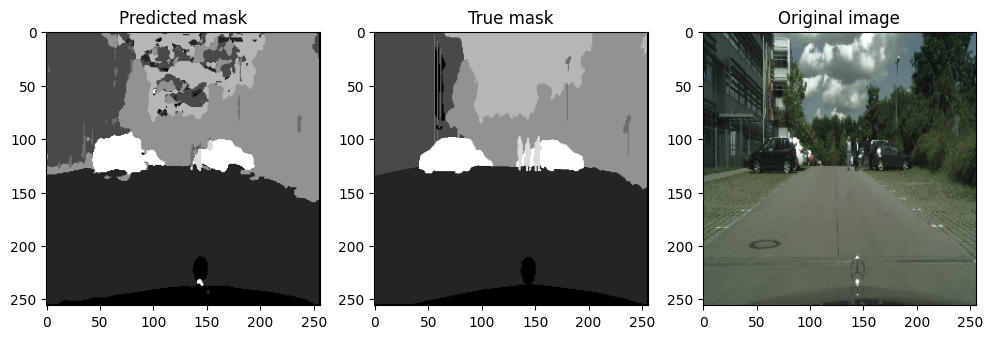

1/1 [==============================] - 0s 38ms/step


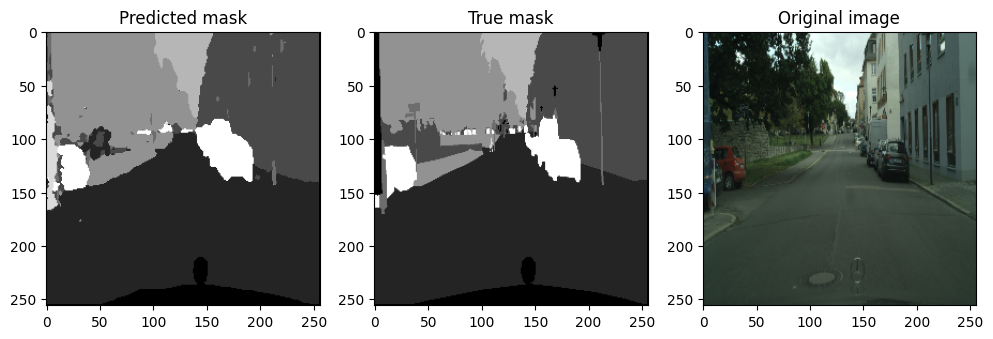

1/1 [==============================] - 0s 38ms/step


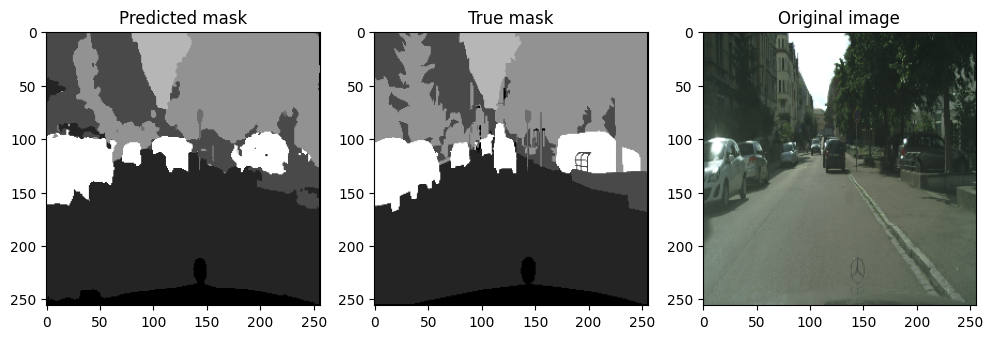

In [9]:
linknet_vgg16_dice = load_model('linknet_vgg16_dice.h5', custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})
display_predictions(model=linknet_vgg16_dice, quantity=3, dims=256)

#### 2.2.5. Architecture: PSPnet, Backbone: Resnet34 (or best backbone)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.5323 - mean_iou: 0.4057
Epoch 1: val_loss improved from inf to 0.64362, saving model to pspnet_vgg16_dice.h5
100/100 [==============================] - 315s 3s/step - loss: 0.5323 - mean_iou: 0.4057 - val_loss: 0.6436 - val_mean_iou: 0.3284
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.4294 - mean_iou: 0.5029
Epoch 2: val_loss improved from 0.64362 to 0.57853, saving model to pspnet_vgg16_dice.h5
100/100 [==============================] - 329s 3s/step - loss: 0.4294 - mean_iou: 0.5029 - val_loss: 0.5785 - val_mean_iou: 0.3704
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3994 - mean_iou: 0.5296
Epoch 3: val_loss improved from 0.57853 to 0.50603, saving model to pspnet_vgg16_dice.h5
100/100 [==============================] - 332s 3s/step - loss: 0.3994 - mean_iou: 0.5296 - val_loss: 0.5060 - val_mean_iou: 0.4312
Epoch 4/10
100/100 [==============================] -

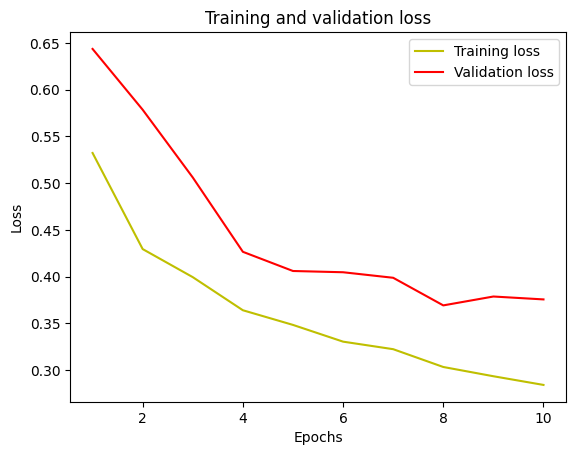

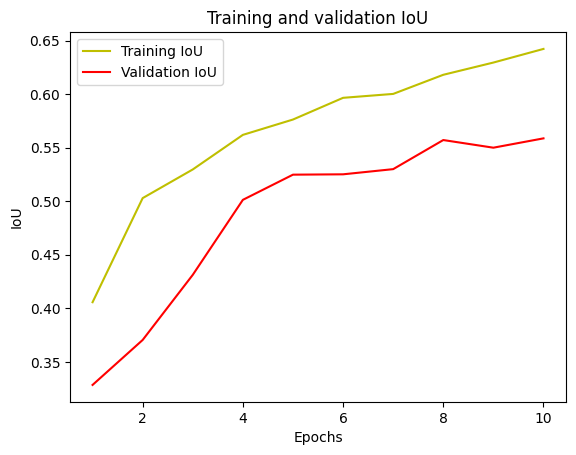

In [10]:
pspnet_vgg16_dice_results = model_test(architecture=sm.PSPNet, backbone='vgg16', filename='pspnet_vgg16_dice', dims=240, loss_function=sm.losses.categorical_focal_dice_loss, augmentation=False)

In [11]:
print(pspnet_vgg16_dice_results)

{'Model name': 'pspnet_vgg16_dice', 'loss': 0.343301922082901, 'mean_iou': 0.5829964876174927, 'Training time': 3252.525507926941}


In [41]:
model_benchmark = model_benchmark.append(pspnet_vgg16_dice_results, ignore_index=True)

1/1 [==============================] - 1s 1s/step


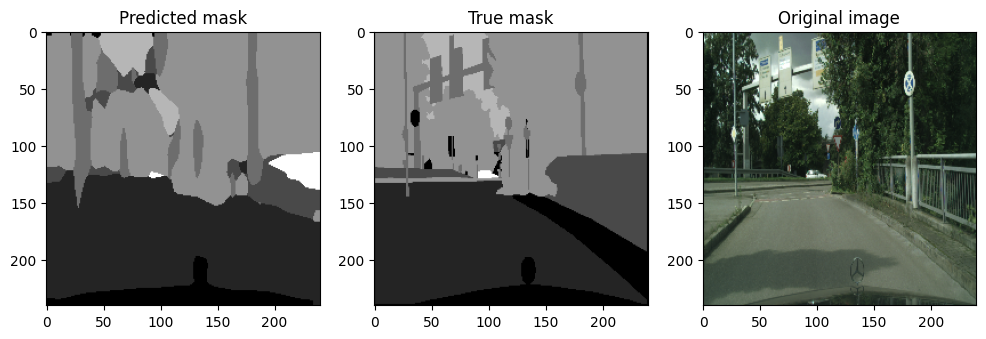

1/1 [==============================] - 0s 35ms/step


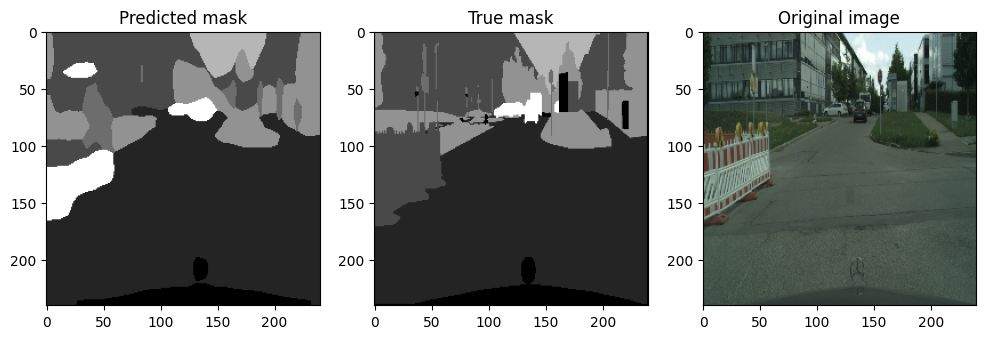

1/1 [==============================] - 0s 34ms/step


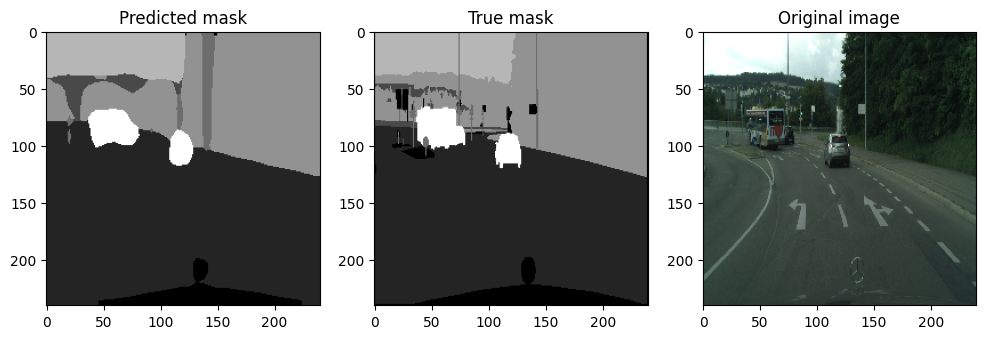

In [12]:
pspnet_vgg16_dice = load_model('pspnet_vgg16_dice.h5', custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})
display_predictions(model=pspnet_vgg16_dice, quantity=3, dims=240)

## 2.3. Model comparison

In [69]:
model_benchmark.to_csv('model_benchmark.csv')
model_benchmark

Model name      Loss  Mean IoU  Training time
0            baseline  0.170532  0.279108    3864.703326
1     unet_vgg16_dice  0.289775  0.637900    3615.027867
2  unet_vgg16_jaccard  0.388676  0.643920    3843.331433
3  unet_resnet34_dice  0.288178  0.643958    4027.296101
4  linknet_vgg16_dice  0.298656  0.629892    3583.629345
5   pspnet_vgg16_dice  0.343302  0.582996    3252.525508

### 2.3.1. Comparing Unet vgg16 dice to unet resnet34 dice

There are two models who perform equally well, they are:  
* U-net architecture with a VGG16 backbone
* U-net architecture with a Resnet34 backbone  

The decision will be made based on the per-class IoU scores. Our labels to category ID associations are the following: void (0), flat (1), construction (2), object (3), nature (4), sky (5), human (6), vehicle (7). The categories which are most important to detect, for the safety of the drivers and pedestrians, is human and vehicle. Let's see how each of these models performs on these categories.

In [74]:
unet_vgg16_dice = load_model('unet_vgg16_dice.h5', custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})
unet_resnet34_dice = load_model('unet_resnet34_dice.h5', custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})

In [75]:
metrics_vgg16 = unet_vgg16_dice.evaluate(test_gen)
metrics_resnet34 = unet_resnet34_dice.evaluate(test_gen)

7/7 [==============================] - 62s 8s/step - loss: 0.2597 - mean_iou: 0.6606


In [76]:
from sklearn.metrics import jaccard_score

In [79]:
dims=256
index=5
model = unet_vgg16_dice

im = cv2.resize(cv2.cvtColor(cv2.imread(x_test_paths_sample[index]), cv2.COLOR_BGR2RGB), (dims,dims))
pred_mask = model.predict(im.reshape(1,dims,dims,3))
pred_mask_argmax = np.argmax(pred_mask, axis=3)

real_mask = cv2.resize((cv2.imread(y_test_paths_sample[index],0)), (dims,dims))
real_mask = coarsify_ohe(real_mask)
real_mask = np.argmax(real_mask, axis=2)

1/1 [==============================] - 2s 2s/step


In [104]:
def iou_classes(batch_imgs, batch_masks, model):

    pred_mask_argmax = []

    img_np = [cv2.resize(cv2.cvtColor(cv2.imread(path_img), cv2.COLOR_BGR2RGB), (256,256)) for path_img in batch_imgs]
    pred_mask = [model.predict(img.reshape(1,256,256,3), verbose=0) for img in img_np]
    pred_mask_argmax = [np.argmax(mask, axis=3) for mask in pred_mask]

    real_mask = [cv2.resize((cv2.imread(path_mask,0)), (256,256)) for path_mask in batch_masks]
    real_mask = [coarsify_ohe(mask) for mask in real_mask]
    real_mask = [(np.argmax(mask, axis=2)) for mask in real_mask]

    pred_mask_argmax = (np.array(pred_mask_argmax)).flatten()
    real_mask = (np.array(real_mask)).flatten()

    per_class_iou = jaccard_score(real_mask, pred_mask_argmax, average=None)

    iou_scores = {
        'Void: ': per_class_iou[0],
        'Flat: ': per_class_iou[0],
        'Construction: ': per_class_iou[0],
        'Object: ': per_class_iou[0],
        'Nature: ': per_class_iou[0],
        'Sky: ': per_class_iou[0],
        'Human: ': per_class_iou[0],
        'Vehicle: ': per_class_iou[0]
    }

    return jaccard_score(real_mask, pred_mask_argmax, average=None)

In [101]:
per_class_iou_vgg = iou_classes(x_test_paths, y_test_paths, unet_vgg16_dice)

In [114]:
iou_scores_vgg = {
        'Name': 'U-Net VGG16',
        'Void': per_class_iou[0],
        'Flat': per_class_iou[1],
        'Construction': per_class_iou[2],
        'Object': per_class_iou[3],
        'Nature': per_class_iou[4],
        'Sky': per_class_iou[5],
        'Human': per_class_iou[6],
        'Vehicle': per_class_iou[7]
}

In [116]:
iou_scores_resnet = {
        'Name': 'U-Net Resnet34',
        'Void': per_class_iou_resnet[0],
        'Flat': per_class_iou_resnet[1],
        'Construction': per_class_iou_resnet[2],
        'Object': per_class_iou_resnet[3],
        'Nature': per_class_iou_resnet[4],
        'Sky': per_class_iou_resnet[5],
        'Human': per_class_iou_resnet[6],
        'Vehicle': per_class_iou_resnet[7]
}

In [117]:
iou_results = pd.DataFrame()
iou_results = iou_results.append(iou_scores_resnet, ignore_index=True)
iou_results = iou_results.append(iou_scores_vgg, ignore_index=True)

In [118]:
iou_results

Name      Void      Flat  Construction    Object    Nature  \
0  U-Net Resnet34  0.656172  0.919015      0.771076  0.267606  0.830486   
1     U-Net VGG16  0.635169  0.902125      0.751915  0.249099  0.824598   

        Sky    Human   Vehicle  
0  0.833696  0.37853  0.738700  
1  0.799696  0.37826  0.691175

In [102]:
per_class_iou_vgg

array([0.63516859, 0.90212504, 0.75191465, 0.24909933, 0.82459764,
       0.79969566, 0.37825974, 0.69117499])

In [103]:
per_class_iou_resnet = iou_classes(x_test_paths, y_test_paths, unet_resnet34_dice)

In [105]:
per_class_iou_resnet

array([0.65617235, 0.91901452, 0.77107649, 0.26760588, 0.83048562,
       0.83369571, 0.37852952, 0.73869984])

#### 2.2.6. Best architecture & backbone on full dataset without augmentation

In [4]:
architecture = sm.Unet
backbone = 'resnet34'
loss = sm.losses.categorical_focal_dice_loss
metrics = [OneHotMeanIoU(num_classes=8, name='mean_iou')]

model = architecture(backbone, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=8, activation='softmax')
model.compile('Adam', loss=loss, metrics=metrics)

In [ ]:
train_gen = DataGenerator(x_train_paths, y_train_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=True, augmentation=False)
val_gen = DataGenerator(x_val_paths, y_val_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=False, augmentation=False)

checkpoint = ModelCheckpoint(filepath='unet_resnet34_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_mean_iou', patience=3, mode='max', min_delta=0.001)

start = time.time()

history = model.fit(
            train_gen, 
            validation_data = val_gen,
            epochs=20,
            #use_multiprocessing=True,
            workers=12,
            callbacks=[checkpoint, early_stopping]
)

end = time.time()
training_time = end-start

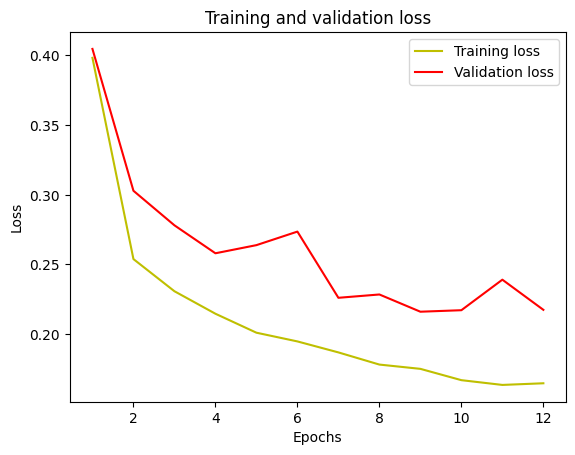

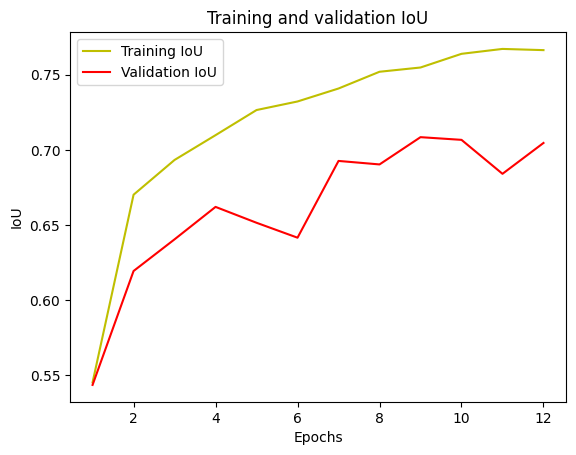

In [121]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mean_iou']
val_acc = history.history['val_mean_iou']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [122]:
test_gen = DataGenerator(x_test_paths, y_test_paths, batch_size=16, shuffle=False, augmentation=False, dims=256, backbone='resnet34')
scores = model.evaluate(test_gen)
print("Training time: " + str(training_time))
print(model.metrics_names)
print("Scores: " + str(scores))

23/23 [==============================] - 229s 10s/step - loss: 0.2108 - mean_iou: 0.7121
Training time: 14420.2822432518
['loss', 'mean_iou']
Scores: [0.21075144410133362, 0.712083101272583]


In [15]:
model_benchmark = model_benchmark.append({
    'Model name': 'unet_resnet34_dice_complete',
    'Loss': scores[0],
    'Mean IoU': scores[1],
    'Training time': training_time
}, ignore_index=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2804\954266276.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_benchmark = model_benchmark.append({


In [16]:
model_benchmark

Model name      Loss  Mean IoU  Training time
0                     baseline  0.170532  0.279108    3864.703326
1              unet_vgg16_dice  0.289775  0.637900    3615.027867
2           unet_vgg16_jaccard  0.388676  0.643920    3843.331433
3           unet_resnet34_dice  0.288178  0.643958    4027.296101
4           linknet_vgg16_dice  0.298656  0.629892    3583.629345
5            pspnet_vgg16_dice  0.343302  0.582996    3252.525508
6  unet_resnet34_dice_complete  0.210751  0.712083   14420.282243

#### 2.2.7. Best architecture & backbone on full dataset with augmentation

In [4]:
architecture = sm.Unet
backbone = 'resnet34'
loss = sm.losses.categorical_focal_dice_loss
metrics = [OneHotMeanIoU(num_classes=8, name='mean_iou')]

model = architecture(backbone, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=8, activation='softmax')
model.compile('Adam', loss=loss, metrics=metrics)

In [5]:
train_gen = DataGenerator(x_train_paths, y_train_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=True, augmentation=True)
val_gen = DataGenerator(x_val_paths, y_val_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=False, augmentation=False)

checkpoint = ModelCheckpoint(filepath='unet_resnet34_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_mean_iou', patience=7, mode='max', min_delta=0.001)

start = time.time()

history = model.fit(
            train_gen, 
            validation_data = val_gen,
            epochs=20,
            #use_multiprocessing=True,
            workers=2,
            callbacks=[checkpoint, early_stopping]
)

end = time.time()
training_time = end-start

Epoch 1/20
327/327 [==============================] - ETA: 0s - loss: 0.4148 - mean_iou: 0.5201
Epoch 1: val_loss improved from inf to 0.32889, saving model to unet_resnet34_aug.h5
327/327 [==============================] - 2130s 6s/step - loss: 0.4148 - mean_iou: 0.5201 - val_loss: 0.3289 - val_mean_iou: 0.5976
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 0.3250 - mean_iou: 0.5928
Epoch 2: val_loss improved from 0.32889 to 0.30953, saving model to unet_resnet34_aug.h5
327/327 [==============================] - 2034s 6s/step - loss: 0.3250 - mean_iou: 0.5928 - val_loss: 0.3095 - val_mean_iou: 0.6210
Epoch 3/20
327/327 [==============================] - ETA: 0s - loss: 0.3097 - mean_iou: 0.6084
Epoch 3: val_loss improved from 0.30953 to 0.25982, saving model to unet_resnet34_aug.h5
327/327 [==============================] - 2024s 6s/step - loss: 0.3097 - mean_iou: 0.6084 - val_loss: 0.2598 - val_mean_iou: 0.6645
Epoch 4/20
327/327 [==============================

In [6]:
test_gen = DataGenerator(x_test_paths, y_test_paths, batch_size=16, shuffle=False, augmentation=False, dims=256, backbone='resnet34')
scores = model.evaluate(test_gen)
print("Training time: " + str(training_time))
print(model.metrics_names)
print("Scores: " + str(scores))

23/23 [==============================] - 202s 9s/step - loss: 0.2159 - mean_iou: 0.7070
Training time: 28410.00834941864
['loss', 'mean_iou']
Scores: [0.21594758331775665, 0.7070083618164062]


In [18]:
model_benchmark = model_benchmark.append({
    'Model name': 'unet_resnet34_dice_complete_aug',
    'Loss': scores[0],
    'Mean IoU': scores[1],
    'Training time': training_time
}, ignore_index=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2804\3921024747.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_benchmark = model_benchmark.append({


In [7]:
model_benchmark = pd.read_csv('model_benchmark.csv')

In [8]:
model_benchmark = model_benchmark.append({
    'Model name': 'unet_resnet34_dice_augmented',
    'Loss': 0.27121642231941223,
    'Mean IoU': 0.6626797914505005,
    'Training time': 6644.559909105301
}, ignore_index=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8360\3839307679.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_benchmark = model_benchmark.append({


In [9]:
model_benchmark

Model name      Loss  Mean IoU  Training time
0                         baseline  0.170532  0.279108    3864.703326
1                  unet_vgg16_dice  0.289775  0.637900    3615.027867
2               unet_vgg16_jaccard  0.388676  0.643920    3843.331433
3               unet_resnet34_dice  0.288178  0.643958    4027.296101
4               linknet_vgg16_dice  0.298656  0.629892    3583.629345
5                pspnet_vgg16_dice  0.343302  0.582996    3252.525508
6      unet_resnet34_dice_complete  0.210751  0.712083   14420.282243
7  unet_resnet34_dice_complete_aug  0.215948  0.707008   28410.008349
8     unet_resnet34_dice_augmented  0.271216  0.662680    6644.559909

In [10]:
model_benchmark.to_csv('model_benchmark.csv', index=False)

In [4]:
architecture = sm.Unet
backbone = 'resnet34'
loss = sm.losses.categorical_focal_dice_loss
metrics = [OneHotMeanIoU(num_classes=8, name='mean_iou')]

model = architecture(backbone, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=8, activation='softmax')
model.compile('Adam', loss=loss, metrics=metrics)

In [5]:
train_gen = DataGenerator(x_train_paths, y_train_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=True, augmentation=True)
val_gen = DataGenerator(x_val_paths, y_val_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=False, augmentation=False)

checkpoint = ModelCheckpoint(filepath='unet_resnet34_augmented.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_mean_iou', patience=3, mode='max', min_delta=0.001)

start = time.time()

history = model.fit(
            train_gen, 
            validation_data = val_gen,
            epochs=20,
            #use_multiprocessing=True,
            workers=2,
            callbacks=[checkpoint, early_stopping]
)

end = time.time()
training_time = end-start

Epoch 1/20
327/327 [==============================] - ETA: 0s - loss: 0.4399 - mean_iou: 0.4943
Epoch 1: val_loss improved from inf to 0.34229, saving model to unet_resnet34_augmented.h5
327/327 [==============================] - 2139s 6s/step - loss: 0.4399 - mean_iou: 0.4943 - val_loss: 0.3423 - val_mean_iou: 0.6046
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 0.3236 - mean_iou: 0.5933
Epoch 2: val_loss improved from 0.34229 to 0.30271, saving model to unet_resnet34_augmented.h5
327/327 [==============================] - 2934s 9s/step - loss: 0.3236 - mean_iou: 0.5933 - val_loss: 0.3027 - val_mean_iou: 0.6418
Epoch 3/20
327/327 [==============================] - ETA: 0s - loss: 0.3073 - mean_iou: 0.6095
Epoch 3: val_loss improved from 0.30271 to 0.28290, saving model to unet_resnet34_augmented.h5
327/327 [==============================] - 2050s 6s/step - loss: 0.3073 - mean_iou: 0.6095 - val_loss: 0.2829 - val_mean_iou: 0.6642
Epoch 4/20
327/327 [============

In [6]:
test_gen = DataGenerator(x_test_paths, y_test_paths, batch_size=8, shuffle=False, augmentation=False, dims=256, backbone='resnet34')
scores = model.evaluate(test_gen)
print("Training time: " + str(training_time))
print(model.metrics_names)
print("Scores: " + str(scores))

45/45 [==============================] - 214s 5s/step - loss: 0.2223 - mean_iou: 0.7111
Training time: 23078.16800713539
['loss', 'mean_iou']
Scores: [0.22225025296211243, 0.7110525369644165]


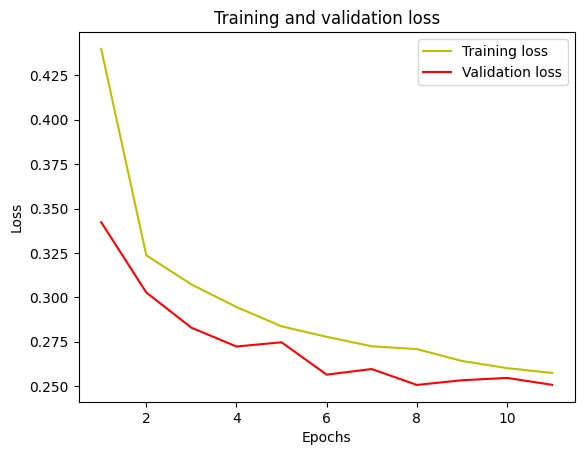

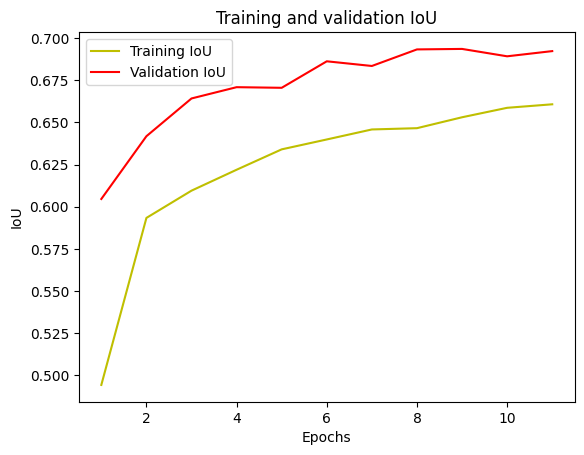

In [7]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mean_iou']
val_acc = history.history['val_mean_iou']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
architecture = sm.Unet
backbone = 'resnet34'
loss = sm.losses.categorical_focal_dice_loss
metrics = [OneHotMeanIoU(num_classes=8, name='mean_iou')]

model = architecture(backbone, encoder_weights='imagenet', 
                input_shape=(256, 256, 3),
                classes=8, activation='softmax')
model.compile('Adam', loss=loss, metrics=metrics)

In [6]:
train_gen = DataGenerator(x_train_paths, y_train_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=True, augmentation=True)
val_gen = DataGenerator(x_val_paths, y_val_paths, batch_size=8, backbone='resnet34', dims=256, shuffle=False, augmentation=False)

checkpoint = ModelCheckpoint(filepath='unet_resnet34_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_mean_iou', patience=7, mode='max', min_delta=0.001)

start = time.time()

history = model.fit(
            train_gen, 
            validation_data = val_gen,
            epochs=20,
            #use_multiprocessing=True,
            workers=2,
            callbacks=[checkpoint, early_stopping]
)

end = time.time()
training_time = end-start

Epoch 1/20
327/327 [==============================] - ETA: 0s - loss: 0.3722 - mean_iou: 0.5659
Epoch 1: val_loss improved from inf to 0.36004, saving model to unet_resnet34_aug.h5
327/327 [==============================] - 2354s 7s/step - loss: 0.3722 - mean_iou: 0.5659 - val_loss: 0.3600 - val_mean_iou: 0.5962
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 0.2719 - mean_iou: 0.6521
Epoch 2: val_loss improved from 0.36004 to 0.33504, saving model to unet_resnet34_aug.h5
327/327 [==============================] - 1977s 6s/step - loss: 0.2719 - mean_iou: 0.6521 - val_loss: 0.3350 - val_mean_iou: 0.6098
Epoch 3/20
327/327 [==============================] - ETA: 0s - loss: 0.2497 - mean_iou: 0.6747
Epoch 3: val_loss improved from 0.33504 to 0.27286, saving model to unet_resnet34_aug.h5
327/327 [==============================] - 1987s 6s/step - loss: 0.2497 - mean_iou: 0.6747 - val_loss: 0.2729 - val_mean_iou: 0.6703
Epoch 4/20
327/327 [==============================

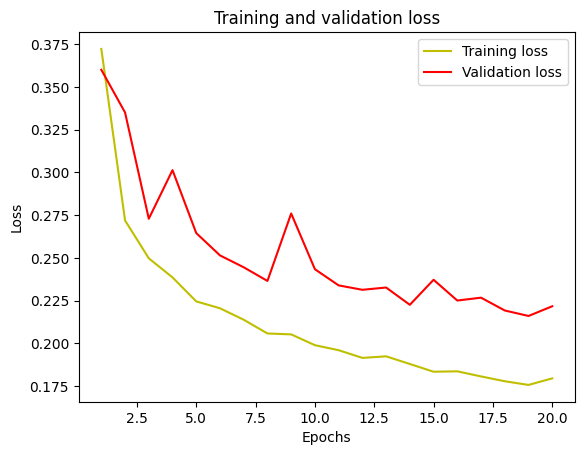

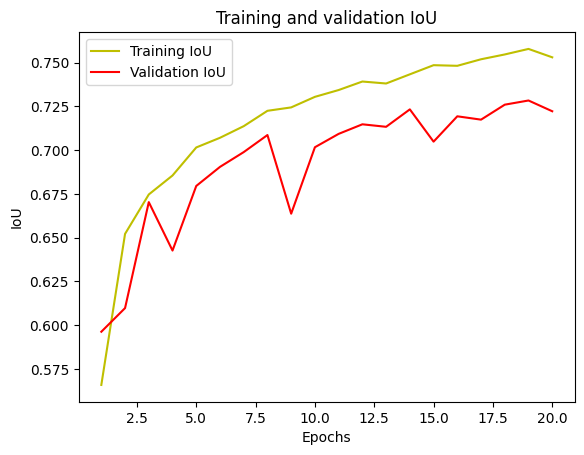

In [7]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mean_iou']
val_acc = history.history['val_mean_iou']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

1/1 [==============================] - 3s 3s/step


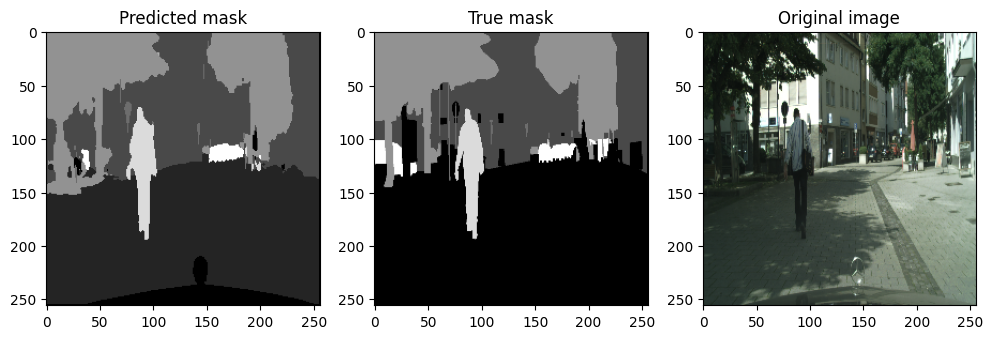

1/1 [==============================] - 0s 49ms/step


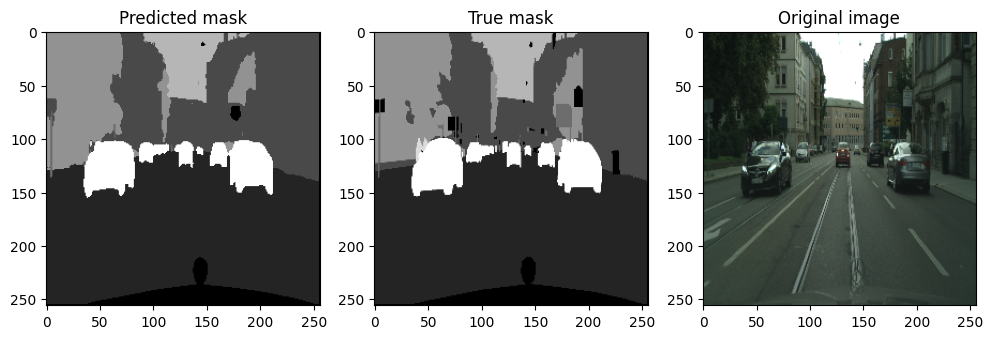

1/1 [==============================] - 0s 46ms/step


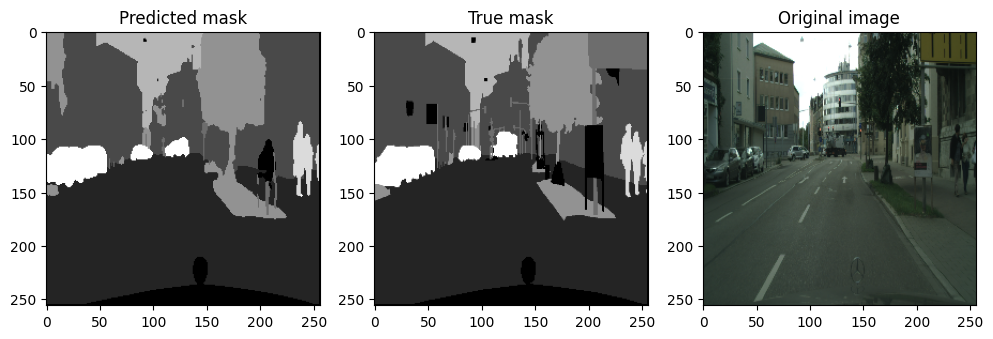

In [13]:
unet_resnet34_aug = load_model('unet_resnet34_aug.h5', custom_objects={'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})
display_predictions(model=unet_resnet34_aug, quantity=3, dims=256)

In [8]:
test_gen = DataGenerator(x_test_paths, y_test_paths, batch_size=8, shuffle=False, augmentation=False, dims=256, backbone='resnet34')
scores = model.evaluate(test_gen)
print("Training time: " + str(training_time))
print(model.metrics_names)
print("Scores: " + str(scores))

45/45 [==============================] - 226s 5s/step - loss: 0.2011 - mean_iou: 0.7333
Training time: 39572.65343213081
['loss', 'mean_iou']
Scores: [0.20105218887329102, 0.7333312034606934]


In [9]:
scores[0]


0.7333312034606934

In [11]:
model_benchmark = pd.read_csv('model_benchmark.csv')
model_benchmark = model_benchmark.append({
    'Model name': 'unet_resnet34_dice_augmented_final',
    'Loss': scores[0],
    'Mean IoU': scores[1],
    'Training time': training_time
}, ignore_index=True)

model_benchmark.to_csv('model_benchmark.csv', index=False)
model_benchmark

C:\Users\Admin\AppData\Local\Temp\ipykernel_3188\2035772050.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_benchmark = model_benchmark.append({


Model name      Loss  Mean IoU  Training time
0                            baseline  0.170532  0.279108    3864.703326
1                     unet_vgg16_dice  0.289775  0.637900    3615.027867
2                  unet_vgg16_jaccard  0.388676  0.643920    3843.331433
3                  unet_resnet34_dice  0.288178  0.643958    4027.296101
4                  linknet_vgg16_dice  0.298656  0.629892    3583.629345
5                   pspnet_vgg16_dice  0.343302  0.582996    3252.525508
6         unet_resnet34_dice_complete  0.210751  0.712083   14420.282243
7     unet_resnet34_dice_complete_aug  0.215948  0.707008   28410.008349
8        unet_resnet34_dice_augmented  0.271216  0.662680    6644.559909
9  unet_resnet34_dice_augmented_final  0.201052  0.733331   39572.653432